In [1]:
# Load libraries  # I only remove duplcate imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.neighbors as nb
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, fbeta_score, make_scorer
from sklearn.naive_bayes import GaussianNB
import sklearn.model_selection as cv
import sklearn.neighbors as nb
from sklearn.metrics import recall_score, make_scorer
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

In [2]:
def get_redundant_pairs(corr):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = corr.columns
    for i in range(0, corr.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(corr, n):
    au_corr = corr.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(corr)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [3]:
def plot_cmatrix(y_test, y_pred_test):
    confmat = confusion_matrix(y_test, y_pred_test)
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(confmat, cmap=plt.cm.Purples, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center',fontsize=10)
    
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    
    plt.tight_layout()
    #plt.savefig('ConMatrixNB_fit_thres.png', dpi=600)
    plt.show()
    print(recall_score(y_test, y_pred_test))
    print(classification_report(y_test, y_pred_test))

In [4]:
# Load data
full_data = pd.read_csv("heart_attack_prediction_indonesia.csv", 
                        na_values=['NA', 'N/A'],
                        keep_default_na=False)

original_columns = full_data.drop(columns=['heart_attack']).columns.tolist()
categorical_columns = ['gender', 'region', 'income_level', 'smoking_status', 
            'alcohol_consumption', 'physical_activity', 'dietary_habits', 
            'air_pollution_exposure', 'stress_level', 'EKG_results']

#full_data['alcohol_consumption'] = full_data['alcohol_consumption'].replace('None', 'No_Alcohol')
#print(full_data['alcohol_consumption'].unique())

# sampled_data, _ = train_test_split(
#     full_data,
#     train_size=20000,
#     stratify=full_data['heart_attack'],
#     random_state=42
# )


full_data.head(n=10)
#sampled_data = full_data.sample(n=20000, random_state=42)
#sampled_data = full_data


,age,gender,region,income_level,hypertension,diabetes,cholesterol_level,obesity,waist_circumference,family_history,...,blood_pressure_diastolic,fasting_blood_sugar,cholesterol_hdl,cholesterol_ldl,triglycerides,EKG_results,previous_heart_disease,medication_usage,participated_in_free_screening,heart_attack
0,60,Male,Rural,Middle,0,1,211,0,83,0,...,62,173,48,121,101,Normal,0,0,0,0
1,53,Female,Urban,Low,0,0,208,0,106,1,...,76,70,58,83,138,Normal,1,0,1,0
2,62,Female,Urban,Low,0,0,231,1,112,1,...,74,118,69,130,171,Abnormal,0,1,0,1
3,73,Male,Urban,Low,1,0,202,0,82,1,...,65,98,52,85,146,Normal,0,1,1,0
4,52,Male,Urban,Middle,1,0,232,0,89,0,...,75,104,59,127,139,Normal,1,0,1,1
5,52,Male,Urban,Middle,0,0,231,1,81,1,...,71,129,34,148,191,Normal,0,1,1,0
6,73,Female,Rural,Low,0,0,238,1,91,0,...,97,88,40,128,167,Normal,0,1,1,0
7,64,Female,Urban,Low,0,1,165,0,72,1,...,83,112,47,100,50,Normal,0,0,1,1
8,49,Female,Urban,Low,0,0,186,0,115,0,...,87,147,46,157,198,Abnormal,0,1,0,0
9,61,Male,Rural,Low,0,0,121,1,88,1,...,87,79,34,93,164,Normal,0,0,0,1


## Check correlations -> If two variables have a correlation > 0.5 between them, we should discard one of them, not to overweight some tendencies 

What do you mean with "overweight some tendencies"? 
This is not a perfectly valid argument (without further explaination). Depending on the context and your particular use case maybe you are interested in keep everything or not in doing that (and depending on what these specific variables mean). In any case this could be done here or in a later step if you have any argument (maybe after the vivariate analysis where you really study how the features are related between each other?).

In [5]:
corr = full_data.drop(columns=categorical_columns)
corr.corr().T.style.background_gradient(cmap = "Oranges")

,age,hypertension,diabetes,cholesterol_level,obesity,waist_circumference,family_history,sleep_hours,blood_pressure_systolic,blood_pressure_diastolic,fasting_blood_sugar,cholesterol_hdl,cholesterol_ldl,triglycerides,previous_heart_disease,medication_usage,participated_in_free_screening,heart_attack
age,1.000000,-0.000512,0.003616,-0.003747,-0.001556,0.001601,0.001046,0.000996,-0.001945,0.001823,0.001721,0.002060,0.000313,0.001071,-0.000475,-0.003072,-0.000620,0.105756
hypertension,-0.000512,1.000000,-0.001329,-0.001085,-0.002454,0.000724,0.000391,0.001773,-0.002323,-0.000049,0.001431,-0.000334,-0.000579,0.000362,-0.004754,0.003349,-0.002905,0.269261
diabetes,0.003616,-0.001329,1.000000,-0.001019,0.001720,-0.001773,-0.001133,0.001436,-0.004286,-0.002648,0.002989,0.000479,0.003871,-0.002776,0.000584,0.002031,-0.002566,0.194512
cholesterol_level,-0.003747,-0.001085,-0.001019,1.000000,-0.000630,-0.000419,-0.002900,0.001566,-0.000771,0.001419,-0.001864,0.003067,0.000929,0.000118,-0.004461,0.003451,-0.000869,0.092611
obesity,-0.001556,-0.002454,0.001720,-0.000630,1.000000,0.395426,0.001415,0.003177,0.001068,-0.000498,0.002241,0.001893,-0.001063,-0.001200,-0.001761,-0.004153,-0.003739,0.171720
waist_circumference,0.001601,0.000724,-0.001773,-0.000419,0.395426,1.000000,0.000109,0.002004,0.000340,0.002217,0.003899,-0.002747,-0.000781,0.000694,0.000844,0.000056,-0.002741,0.067883
family_history,0.001046,0.000391,-0.001133,-0.002900,0.001415,0.000109,1.000000,0.001150,-0.000897,0.002180,0.004453,-0.004747,0.002161,-0.000026,0.001014,-0.000015,0.002573,0.001374
sleep_hours,0.000996,0.001773,0.001436,0.001566,0.003177,0.002004,0.001150,1.000000,-0.000589,0.003410,-0.001069,-0.002888,-0.001024,-0.002672,0.002168,0.003941,-0.002101,0.000673
blood_pressure_systolic,-0.001945,-0.002323,-0.004286,-0.000771,0.001068,0.000340,-0.000897,-0.000589,1.000000,-0.002384,-0.001058,-0.005929,0.001367,-0.003280,0.003781,0.000549,0.001929,-0.001644
blood_pressure_diastolic,0.001823,-0.000049,-0.002648,0.001419,-0.000498,0.002217,0.002180,0.003410,-0.002384,1.000000,-0.000854,0.001408,-0.002969,-0.000498,-0.004296,0.002096,0.000923,-0.000301


In [6]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(corr, 9))

Top Absolute Correlations
obesity                 waist_circumference    0.395426
previous_heart_disease  heart_attack           0.274775
hypertension            heart_attack           0.269261
diabetes                heart_attack           0.194512
obesity                 heart_attack           0.171720
age                     heart_attack           0.105756
cholesterol_level       heart_attack           0.092611
fasting_blood_sugar     heart_attack           0.069826
waist_circumference     heart_attack           0.067883
dtype: float64


In [7]:
full_data.describe(include=object)

,gender,region,income_level,smoking_status,alcohol_consumption,physical_activity,dietary_habits,air_pollution_exposure,stress_level,EKG_results
count,158355,158355,158355,158355,158355,158355,158355,158355,158355,158355
unique,2,2,3,3,3,3,2,3,3,2
top,Male,Urban,Middle,Never,None,Low,Unhealthy,Moderate,Moderate,Normal
freq,82243,103038,71230,79183,94848,63417,95030,79144,79366,126914


In [8]:
full_data.groupby('heart_attack').size()

heart_attack
0    94854
1    63501
dtype: int64

<Axes: xlabel='heart_attack'>

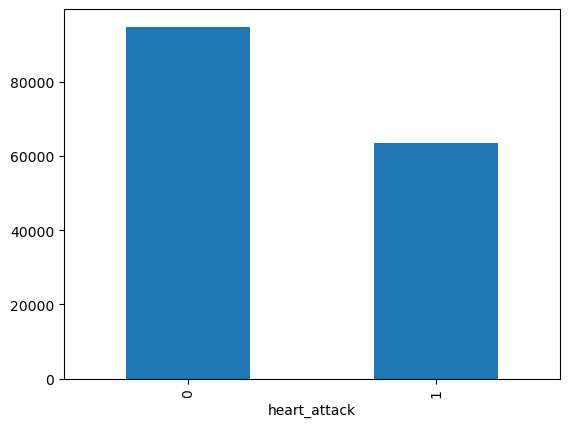

In [9]:
full_data.heart_attack.value_counts().plot(kind='bar')

## We now want to create a sample that will be used to train models, and applying different methods in order to maximize the recall (ensure true heart attacks are always detected). If the methods give good results, I will apply them to the whole dataset.

-> This separation between tests should be done at the end of the process unless you want to comparte different models trained exactly with the same data split (could be interesting in some cases, but is not what we require you to do). **We can talk about this during** the next class if your are interested in this.

In [10]:
y = full_data['heart_attack']
X = full_data.drop(columns=['heart_attack'])

In [11]:
sampled_data, _ = train_test_split(
    full_data,
    train_size=20000,
    stratify=full_data['heart_attack'],
    random_state=42

)

y_sampled = sampled_data['heart_attack']
X_sampled = sampled_data.drop(columns=['heart_attack'])


# Train-test split on the sampled data (BEFORE preprocessing)
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, test_size=0.3, stratify=y_sampled, random_state=42 # random_state always with the same fixed value -> data split always the same; random_state = none -> each execution
    # will generate random values, and both data training and testing sets will differ for each execution
    # test_size = 0.3 -> 30% for data testing
    # For now, we keep it at 42 for reproducivility (we use 42 because it's the answer to the Ultimate Question of Life, the Universe, and Everything is 42)
)

## We apply OneHotEncodeing for the training + test samples, and also for the whole dataset

-> Would be a good idea to check first (before taking dummies) the number of different elements in each category to avoid increase a lot (potencially) the computational cost of the training.




In [12]:
full_data.describe(include=object)

,gender,region,income_level,smoking_status,alcohol_consumption,physical_activity,dietary_habits,air_pollution_exposure,stress_level,EKG_results
count,158355,158355,158355,158355,158355,158355,158355,158355,158355,158355
unique,2,2,3,3,3,3,2,3,3,2
top,Male,Urban,Middle,Never,None,Low,Unhealthy,Moderate,Moderate,Normal
freq,82243,103038,71230,79183,94848,63417,95030,79144,79366,126914


## All the categorical features seam to have few unique values
The increase of the computational load due to applying OHE should be negligible

In [13]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

X = pd.get_dummies(X, drop_first=True)

## We apply undersampling first to the model, so we can see if the recall improves


** Cross-val results (undersampled data):


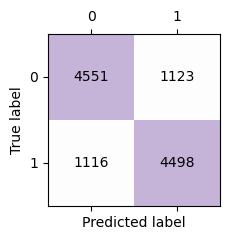

0.8012112575703598
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      5674
           1       0.80      0.80      0.80      5614

    accuracy                           0.80     11288
   macro avg       0.80      0.80      0.80     11288
weighted avg       0.80      0.80      0.80     11288


** Test set results:


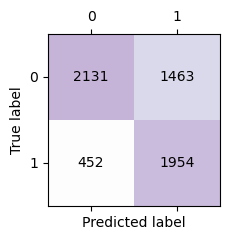

0.8121363258520365
              precision    recall  f1-score   support

           0       0.83      0.59      0.69      3594
           1       0.57      0.81      0.67      2406

    accuracy                           0.68      6000
   macro avg       0.70      0.70      0.68      6000
weighted avg       0.72      0.68      0.68      6000



In [14]:


# 1. Undersample the training data
undersampler = InstanceHardnessThreshold(random_state=42)
XtrainEbal, ybal = undersampler.fit_resample(X_train, y_train)  # X_train must be preprocessed

# 2. Cross-validate ON UNDERSAMPLED DATA
cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
model = GaussianNB()

# Get predictions for UNDERSAMPLED DATA via cross-validation
y_pred_cv = cross_val_predict(model, XtrainEbal, ybal, cv=cv)

# 3. Test on ORIGINAL TEST SET (requires refitting)
model.fit(XtrainEbal, ybal)  # Train on full undersampled data
y_pred_test = model.predict(X_test)  # X_test must be preprocessed same as X_train

# 4. Show results
print("\n** Cross-val results (undersampled data):")
plot_cmatrix(ybal, y_pred_cv)
#print(classification_report(ybal, y_pred_cv))
# print("Confusion matrix (CV):\n", confusion_matrix(ybal, y_pred_cv))

print("\n** Test set results:")
#print(classification_report(y_test, y_pred_test))
#print("Confusion matrix (test):\n", confusion_matrix(y_test, y_pred_test))

plot_cmatrix(y_test, y_pred_test)


## We get a much better result for recall than before
(maybe add the confusion matrix before balancing, so it's clearer)

In [15]:
XtrainEbal

,age,hypertension,diabetes,cholesterol_level,obesity,waist_circumference,family_history,sleep_hours,blood_pressure_systolic,blood_pressure_diastolic,...,alcohol_consumption_Moderate,alcohol_consumption_None,physical_activity_Low,physical_activity_Moderate,dietary_habits_Unhealthy,air_pollution_exposure_Low,air_pollution_exposure_Moderate,stress_level_Low,stress_level_Moderate,EKG_results_Normal
0,59,0,0,160,0,104,1,6.468796,144,87,...,True,False,True,False,False,False,False,True,False,True
1,42,0,0,180,0,82,0,7.394196,126,70,...,True,False,False,True,True,False,True,False,True,False
2,60,0,0,258,0,96,0,7.111928,131,89,...,True,False,False,True,True,False,True,False,True,True
3,41,0,0,146,0,94,1,6.818875,107,86,...,False,True,True,False,True,True,False,True,False,True
4,45,0,0,234,0,106,0,5.335809,122,66,...,True,False,True,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11283,63,1,0,147,0,58,1,3.502006,128,73,...,False,True,True,False,True,True,False,True,False,True
11284,82,0,0,177,1,74,0,6.045760,140,84,...,False,False,False,False,True,False,True,True,False,True
11285,44,1,1,175,1,133,0,7.727788,125,80,...,True,False,True,False,False,False,False,False,False,True
11286,30,1,1,101,0,78,0,6.213072,126,84,...,False,True,False,True,False,True,False,False,True,True


## Since we got a much better result, we will apply the undersampling to the whole dataset, and save the full undersampled dataset to a file

(We want different versions of the dataset, so we can compare how good they perform for each algorithm, and choose the most appropriate one for each)

In [16]:
X_balanced, y_balanced = undersampler.fit_resample(X, y)


In [17]:
# X_balanced['heart_attack'] = y_balanced
# full_data_balanced = X_balanced

full_data_balanced = X_balanced
full_data_balanced['heart_attack'] = y_balanced


full_data_balanced

,age,hypertension,diabetes,cholesterol_level,obesity,waist_circumference,family_history,sleep_hours,blood_pressure_systolic,blood_pressure_diastolic,...,alcohol_consumption_None,physical_activity_Low,physical_activity_Moderate,dietary_habits_Unhealthy,air_pollution_exposure_Low,air_pollution_exposure_Moderate,stress_level_Low,stress_level_Moderate,EKG_results_Normal,heart_attack
0,52,0,0,231,1,81,1,8.249088,131,71,...,True,True,False,True,True,False,False,True,True,0
1,49,0,0,186,0,115,0,5.224819,150,87,...,False,True,False,False,False,True,True,False,False,0
2,57,0,0,234,0,70,0,8.711160,146,77,...,False,True,False,False,False,False,False,True,True,0
3,32,0,0,193,0,74,1,7.725066,145,54,...,False,False,False,True,False,False,False,True,True,0
4,48,0,0,134,0,77,0,6.569514,138,83,...,True,True,False,False,False,True,False,True,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127025,40,0,0,137,1,94,0,6.242394,145,79,...,True,False,True,False,False,True,False,True,False,1
127026,33,1,0,204,0,108,1,8.119747,131,80,...,True,True,False,True,False,True,False,True,True,1
127027,64,0,0,179,0,93,0,7.451146,132,73,...,True,False,True,False,False,False,False,False,True,1
127028,30,0,0,220,0,78,0,8.008676,133,87,...,False,True,False,False,True,False,False,True,False,1


In [18]:
full_data_balanced.to_csv("data_balanced.csv", index=False)

<Axes: xlabel='heart_attack'>

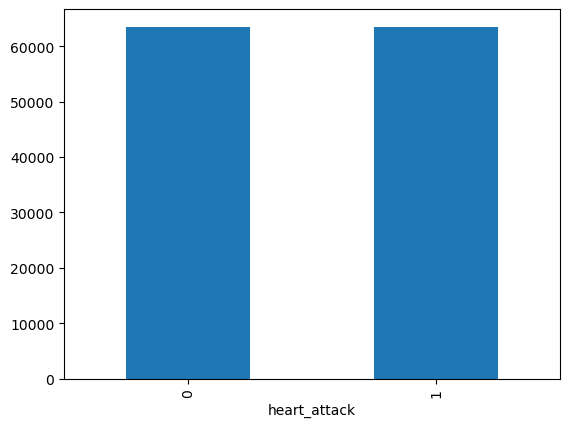

In [19]:
full_data_balanced.heart_attack.value_counts().plot(kind='bar')

## We now apply standardization, since some models like Knn need it to work properly

In [20]:
scaler = StandardScaler()
XtrainEbal = scaler.fit_transform(XtrainEbal)
X_test = scaler.transform(X_test)  # Use the same scaler

X_balanced = scaler.fit_transform(X_balanced)

Best Params = {'n_neighbors': 7, 'weights': 'distance'} Recall (Class 1) = 0.763440982993003


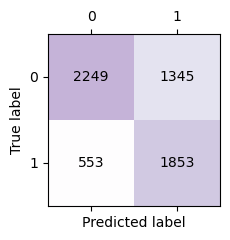

0.7701579384871156
              precision    recall  f1-score   support

           0       0.80      0.63      0.70      3594
           1       0.58      0.77      0.66      2406

    accuracy                           0.68      6000
   macro avg       0.69      0.70      0.68      6000
weighted avg       0.71      0.68      0.69      6000



In [30]:
params = {
    "n_neighbors":list(range(1,20,2)), 
    "weights":('distance','uniform')
}
knc = nb.KNeighborsClassifier()

# 1. Create a custom scorer for recall of class 1
recall_scorer = make_scorer(recall_score, pos_label=1)

# 2. Select k best features (assuming X_new and y_train are defined)
selector = SelectKBest(mutual_info_classif, k=7)
X_reduced = selector.fit_transform(XtrainEbal, ybal)
X_test_reduced = selector.transform(X_test)

# 3. Define cross-validation strategy
cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

# 4. Update GridSearchCV to use recall_scorer
clf = GridSearchCV(
    knc, 
    param_grid=params, 
    cv=cv, 
    scoring=recall_scorer,  # Critical change here
    n_jobs=-1
)
clf.fit(X_reduced, ybal)


# 5. Print results
print("Best Params =", clf.best_params_, "Recall (Class 1) =", clf.best_score_)

knc.fit(X_reduced, ybal)
y_pred_test = knc.predict(X_test_reduced)

plot_cmatrix(y_test, y_pred_test)

## We can see that the standardization of the data gives us fairly good results for the recall

In [24]:
XtrainEbal.shape

(11288, 33)

## We will now see which are the K best features, which give us best results (or more useful prediction) for KNN

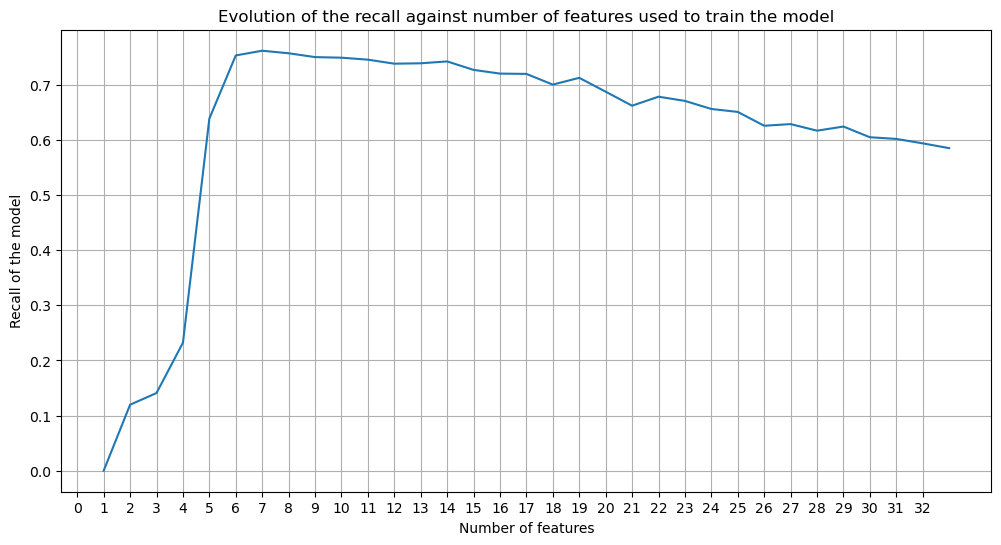

In [31]:
original = np.zeros(33)
for i in range(33):
    X_reduced = SelectKBest(mutual_info_classif, k=i+1).fit_transform(XtrainEbal, ybal)
    cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_scores = cross_val_score(nb.KNeighborsClassifier(), X=X_reduced,y=ybal, cv=cv, scoring='recall')  
    original[i]=np.mean(cv_scores)
    
fig = plt.figure(figsize = (12, 6))  # Just declare the figure object and give dimensions
plt.grid(True)
plt.title("Evolution of the recall against number of features used to train the model")
plt.ylabel("Recall of the model")
plt.xlabel("Number of features")
plt.xticks(np.arange(0, 33, step=1))
plt.plot(range(1,34), original)
plt.show()

## We can see that the best value for K is 7, which is the one we already used in our previous example

However, I'll not add it to the feature selection, since the elimination of irrelevant features are more important for algorithms like KNN (in where we'll repeat this process more in detail, and this k is checked to be better just for it), and I'd better not remove an arbitrary number features with the least mi scores

## Now, we will apply the standardization in our entire dataset, and save a version with our full data + nomalization

In [32]:
scaler = StandardScaler()
num_d = [x for x in full_data_balanced.columns if x != "heart_attack"]
# update the cols with their normalized values
full_data_balanced_normalized = full_data_balanced
full_data_balanced_normalized[num_d] = scaler.fit_transform(full_data_balanced_normalized[num_d])

full_data_balanced_normalized


,age,hypertension,diabetes,cholesterol_level,obesity,waist_circumference,family_history,sleep_hours,blood_pressure_systolic,blood_pressure_diastolic,...,alcohol_consumption_None,physical_activity_Low,physical_activity_Moderate,dietary_habits_Unhealthy,air_pollution_exposure_Low,air_pollution_exposure_Moderate,stress_level_Low,stress_level_Moderate,EKG_results_Normal,heart_attack
0,-0.191687,-0.611612,-0.473831,0.819943,1.807022,-0.733750,1.527153,1.243393,0.098037,-0.851704,...,0.81734,1.224544,-0.812739,0.816858,1.528958,-0.998836,-0.498499,0.996715,0.495654,0
1,-0.445728,-0.611612,-0.473831,-0.325946,-0.553397,1.350383,-0.654813,-0.882546,1.367177,0.754118,...,-1.22348,1.224544,-0.812739,-1.224203,-0.654040,1.001166,2.006022,-1.003296,-2.017536,0
2,0.231714,-0.611612,-0.473831,0.896336,-0.553397,-1.408028,-0.654813,1.568211,1.099990,-0.249521,...,-1.22348,1.224544,-0.812739,-1.224203,-0.654040,-0.998836,-0.498499,0.996715,0.495654,0
3,-1.885292,-0.611612,-0.473831,-0.147697,-0.553397,-1.162836,1.527153,0.875027,1.033193,-2.557890,...,-1.22348,-0.816630,-0.812739,0.816858,-0.654040,-0.998836,-0.498499,0.996715,0.495654,0
4,-0.530408,-0.611612,-0.473831,-1.650085,-0.553397,-0.978942,-0.654813,0.062720,0.565615,0.352663,...,0.81734,1.224544,-0.812739,-1.224203,-0.654040,1.001166,-0.498499,0.996715,0.495654,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127025,-1.207850,-0.611612,-0.473831,-1.573692,1.807022,0.063124,-0.654813,-0.167232,1.033193,-0.048793,...,0.81734,-0.816630,1.230407,-1.224203,-0.654040,1.001166,-0.498499,0.996715,-2.017536,1
127026,-1.800612,1.635022,-0.473831,0.132409,-0.553397,0.921297,1.527153,1.152472,0.098037,0.051571,...,0.81734,1.224544,-0.812739,0.816858,-0.654040,1.001166,-0.498499,0.996715,0.495654,1
127027,0.824475,-0.611612,-0.473831,-0.504196,-0.553397,0.001826,-0.654813,0.682472,0.164834,-0.650976,...,0.81734,-0.816630,1.230407,-1.224203,-0.654040,-0.998836,-0.498499,-1.003296,0.495654,1
127028,-2.054652,-0.611612,-0.473831,0.539837,-0.553397,-0.917644,-0.654813,1.074393,0.231631,0.754118,...,-1.22348,1.224544,-0.812739,-1.224203,1.528958,-0.998836,-0.498499,0.996715,-2.017536,1


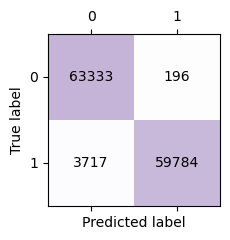

0.9414654887324609
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     63529
           1       1.00      0.94      0.97     63501

    accuracy                           0.97    127030
   macro avg       0.97      0.97      0.97    127030
weighted avg       0.97      0.97      0.97    127030



In [33]:
y_pred_cv = cross_val_predict(nb.KNeighborsClassifier(), X_balanced, y_balanced, cv=cv)

plot_cmatrix(y_balanced, y_pred_cv)

In [54]:
full_data_balanced_normalized.to_csv("data_balanced_normalized.csv", index=False)